# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

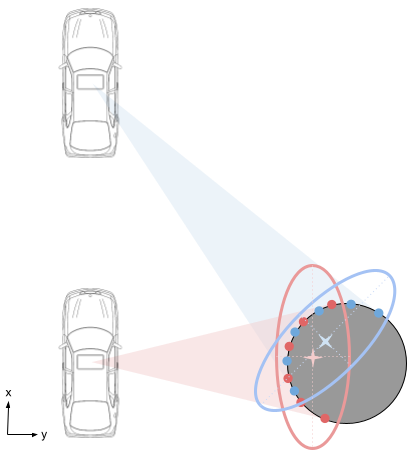

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample 25 points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

TODO- try translating data of 2nd scan forward and back to account for preliminary convergence of ICET- ideally, network should work with this as well

In [6]:
#setup - rememeber to switch to dnn kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [2]:
#import training data
#toy data set
# d1 = np.loadtxt('training_data/scan1.txt')
# d2 = np.loadtxt('training_data/scan2.txt')
# gt = np.loadtxt('training_data/ground_truth.txt')

#slightly larger prism dataset
d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1.txt")
d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2.txt")
gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth.txt")

points_per_sample = 50 #25 #num pts per scan - defined in MatLab script
scan1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
scan2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
gt = tf.convert_to_tensor(gt)
# print(tf.shape(scan1))
# print(tf.shape(gt))

#split data into training and validation sets
tsplit = 0.8 #this fraction goes into training
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())
x_train = tf.concat((scan1[:ntrain], scan2[:ntrain]), axis = 1)
x_test = tf.concat((scan1[ntrain:], scan2[ntrain:]), axis = 1)
y_train = gt[:ntrain]
y_test = gt[ntrain:]

# x_train = tf.reshape(x_train, [-1, 50, 1, 1, 1])
print(tf.shape(x_train))
# x_train = tf.reshape(x_train, [-1, 50, 3])

# print(x_train[0,0,:])

tf.Tensor([12800   100     3], shape=(3,), dtype=int32)


In [3]:
#train network
from network import Net
# from network import permNet as Net
# from network import PointNet as Net
np.random.seed(1337)

runLen = 300

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.0025 #0.005
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.001 #0.0025
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00025 #0.0005
        return learning_rate

model = Net()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = tf.keras.losses.MeanSquaredError())

summary = model.summary()
print(summary)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 128, epochs=runLen, verbose=1, 
                  validation_split = 0.2, shuffle=True, callbacks = [callback, tensorboard_callback])
#add to callback to use stepped learning rate

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 3)]          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 3)            12        
_________________________________________________________________
dense (Dense)                (None, 100, 64)           256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 64)           256       
_________________________________________________________________
dense_1 (Dense)              (None, 100, 64)           4160      
_________________________________________________________________
reshape (Reshape)            (None, 100, 8, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 4, 8)         

Epoch 55/300
80/80 [==============================] - 0s 4ms/step - loss: 5.2673 - val_loss: 9.8161
Epoch 56/300
80/80 [==============================] - 0s 4ms/step - loss: 5.3935 - val_loss: 21.8150
Epoch 57/300
80/80 [==============================] - 0s 4ms/step - loss: 5.2890 - val_loss: 9.8054
Epoch 58/300
80/80 [==============================] - 0s 4ms/step - loss: 5.5849 - val_loss: 32.9664
Epoch 59/300
80/80 [==============================] - 0s 4ms/step - loss: 5.5126 - val_loss: 28.2757
Epoch 60/300
80/80 [==============================] - 0s 4ms/step - loss: 5.2973 - val_loss: 22.4165
Epoch 61/300
80/80 [==============================] - 0s 4ms/step - loss: 5.3561 - val_loss: 16.6066
Epoch 62/300
80/80 [==============================] - 0s 4ms/step - loss: 5.3933 - val_loss: 9.6639
Epoch 63/300
80/80 [==============================] - 0s 4ms/step - loss: 5.4595 - val_loss: 15.7581
Epoch 64/300
80/80 [==============================] - 0s 4ms/step - loss: 5.3749 - val_loss: 2

Epoch 136/300
80/80 [==============================] - 0s 4ms/step - loss: 3.9087 - val_loss: 18.6882
Epoch 137/300
80/80 [==============================] - 0s 4ms/step - loss: 3.9906 - val_loss: 9.2027
Epoch 138/300
80/80 [==============================] - 0s 4ms/step - loss: 3.9682 - val_loss: 10.5893
Epoch 139/300
80/80 [==============================] - 0s 4ms/step - loss: 4.0642 - val_loss: 4.9320
Epoch 140/300
80/80 [==============================] - 0s 4ms/step - loss: 3.9354 - val_loss: 12.7235
Epoch 141/300
80/80 [==============================] - 0s 4ms/step - loss: 4.1760 - val_loss: 5.4582
Epoch 142/300
80/80 [==============================] - 0s 4ms/step - loss: 3.9589 - val_loss: 6.5021
Epoch 143/300
80/80 [==============================] - 0s 4ms/step - loss: 3.8747 - val_loss: 14.6672
Epoch 144/300
80/80 [==============================] - 0s 4ms/step - loss: 3.9939 - val_loss: 16.4241
Epoch 145/300
80/80 [==============================] - 0s 4ms/step - loss: 3.8876 - va

Epoch 217/300
80/80 [==============================] - 0s 4ms/step - loss: 3.1354 - val_loss: 5.8527
Epoch 218/300
80/80 [==============================] - 0s 4ms/step - loss: 3.1429 - val_loss: 4.3046
Epoch 219/300
80/80 [==============================] - 0s 4ms/step - loss: 3.1468 - val_loss: 4.5707
Epoch 220/300
80/80 [==============================] - 0s 4ms/step - loss: 3.1655 - val_loss: 4.9950
Epoch 221/300
80/80 [==============================] - 0s 4ms/step - loss: 3.0989 - val_loss: 4.7148
Epoch 222/300
80/80 [==============================] - 0s 4ms/step - loss: 3.0745 - val_loss: 4.1367
Epoch 223/300
80/80 [==============================] - 0s 4ms/step - loss: 3.1874 - val_loss: 4.3170
Epoch 224/300
80/80 [==============================] - 0s 4ms/step - loss: 3.0777 - val_loss: 4.6371
Epoch 225/300
80/80 [==============================] - 0s 4ms/step - loss: 3.1359 - val_loss: 4.0729
Epoch 226/300
80/80 [==============================] - 0s 4ms/step - loss: 3.1632 - val_los

80/80 [==============================] - 0s 5ms/step - loss: 2.9434 - val_loss: 5.9066
Epoch 299/300
80/80 [==============================] - 0s 4ms/step - loss: 2.9982 - val_loss: 5.8229
Epoch 300/300
80/80 [==============================] - 0s 4ms/step - loss: 3.0199 - val_loss: 6.2401


<IPython.core.display.Javascript object>


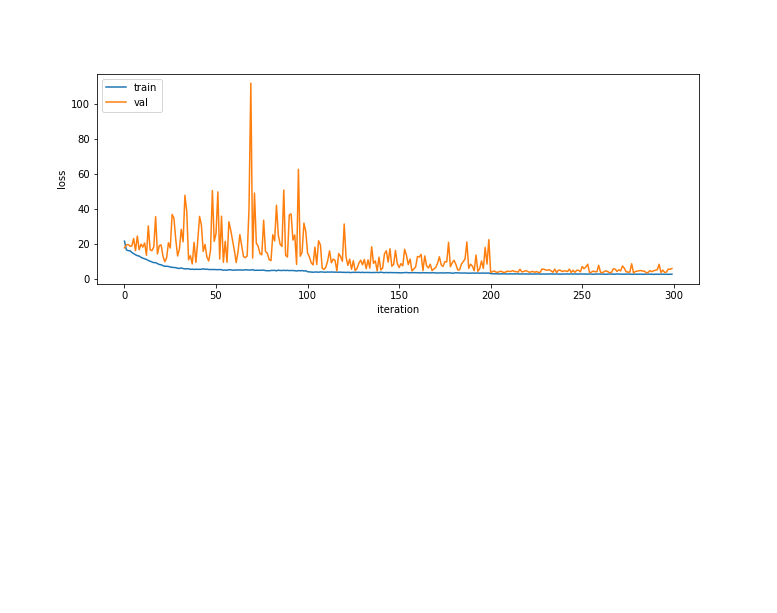

Text(0, 0.5, 'loss')

In [7]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

In [8]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])

estimates = model.predict(x_test[0:100:16])
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[0:100:16])

err = y_test[0:100:16] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

#MSE
print(tf.math.reduce_mean(tf.math.reduce_sum(err**2, axis = 1)/3))




estimated translation x y z
[[ 8.0168676e-01 -8.2945423e+00 -1.1017433e-03]
 [-3.7314263e-01 -4.0593529e+00 -8.9684571e-04]
 [ 3.1116028e+00  4.8279762e+00 -3.5047426e-03]
 [-6.2128353e+00  4.3444610e+00  6.6377677e-04]
 [-4.3651918e-01 -6.5268493e+00 -4.4974789e-04]
 [-3.4172726e+00 -7.0639377e+00 -9.6108398e-04]
 [-9.4545913e-01 -6.6466784e+00 -1.0239626e-03]]
actual translation x y z
tf.Tensor(
[[ 3.37269809e-01 -9.57266712e+00  2.68604391e-03]
 [-1.96085254e+00  5.10573459e-01 -7.21609406e-04]
 [ 5.20522164e+00 -2.19058852e+00 -4.11497939e-03]
 [-6.65937775e+00  7.07309370e+00  1.35498431e-02]
 [ 9.57215009e-01 -6.33825163e+00 -1.04087588e-02]
 [-4.37474478e+00 -3.80928630e+00  2.51059720e-03]
 [-2.76835610e+00 -3.64676131e-01  1.44401740e-02]], shape=(7, 3), dtype=float64)

 Error 
 tf.Tensor(
[[-4.64416954e-01 -1.27812481e+00  3.78778722e-03]
 [-1.58770991e+00  4.56992633e+00  1.75236305e-04]
 [ 2.09361886e+00 -7.01856474e+00 -6.10236754e-04]
 [-4.46542436e-01  2.72863274e+00  1.

### Top scores:
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)